

# A simple CNN model using the extracted features from create_features_from_PC-GITA.py

- Old notebook now, but usefull to look into the headers of the features we can choose from
    - print(features["Phonation"]["PD"].keys().to_list())

- This is getting all the features first and then sorting out what type of the data you want. 

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

2023-11-21 17:43:20.819487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 17:43:20.819508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 17:43:20.820302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 17:43:20.824495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 17:43:21.360832: W tensorflow/compiler/tf2

In [2]:
# List of all HC and PD words used in PC-GITA
HC_strings = ["HC", "hc", "Control"]  # Only need to have HC in the name, we have: HC_las_que_sobraron as well
PD_strings = ["PD", "pd", "Patologica",
              "Patalogica"]  # Only need to have PD in the name, we have: PD_las_que_sobraron as well

In [3]:

path = "PC-GITA-static-features/sentences/micasa/sin_normalizar"
# path = "PC-GITA-static-features/Vowels/"

features_strings = ["Phonation", "Articulation", "Prosody"]

features = {}  # Dict with {Phonation: {PD: pd, HC: pd, que_sobra_PD: pd, que_sobra_HC: pd},
#                          Articulation: {PD: pd, HC: pd, que_sobra_PD: pd, que_sobra_HC: pd}
#                          Prosody: {PD: pd, HC: pd, que_sobra_PD: pd, que_sobra_HC: pd}}
for elem in features_strings:
    features[elem] = {}

for dirpath, dirnames, filenames in os.walk(path):
    if filenames != []:
        is_PD = [elem for elem in PD_strings if elem in dirpath]
        is_HC = [elem for elem in HC_strings if elem in dirpath]
        is_que_sobra = "que_sobra" in dirpath
        if is_HC and not is_que_sobra:
            for filename in filenames:
                features[filename.split(".csv")[0]]["HC"] = pd.read_csv(dirpath + "/" + filename)

        elif is_PD and not is_que_sobra:
            for filename in filenames:
                features[filename.split(".csv")[0]]["PD"] = pd.read_csv(dirpath + "/" + filename)

        elif is_HC and is_que_sobra:  # is_que_sobra is true
            for filename in filenames:
                features[filename.split(".csv")[0]]["que_sobra_HC"] = pd.read_csv(dirpath + "/" + filename)

        else:
            for filename in filenames:
                features[filename.split(".csv")[0]]["que_sobra_PD"] = pd.read_csv(dirpath + "/" + filename)

display(features["Prosody"]["HC"].iloc[2:4])
print(len(features["Prosody"]))



,F0avg,F0std,F0max,F0min,F0skew,F0kurt,F0tiltavg,F0mseavg,F0tiltstd,F0msestd,...,kurtosisdurpause,maxdurpause,mindurpause,PVU,PU,UVU,VVU,VP,UP,id
2,218.154953,33.933617,317.766205,141.064941,-0.184229,0.570542,-101.631581,142.863649,158.569029,78.664791,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,AVPEPUDEAC0004_micasa.wav
3,170.301437,28.326609,230.898148,88.317535,-1.136096,0.423945,-127.325662,54.050654,148.853460,42.440836,...,NaN,0.17,0.17,0.631579,4.0,0.157895,0.842105,1.333333,0.25,AVPEPUDEAC0005_micasa.wav


4


In [4]:
def plot_features(choosen_features, feature_types):
    """
    Function to plot given features and find average between all people. 
    
    choosen_features: dict with HC and PC and then pd of all the feature values of the poeple we have data for. 
    y_label: Text that explaines what type of feature it is. 
    """

    HC = np.array(choosen_features["HC"])
    PD = np.array(choosen_features["PD"])

    num_HC = len(HC)
    num_PD = len(PD)

    for i in range(len(feature_types)):
        avgHC = np.average(HC[:, i])
        avgPD = np.average(PD[:, i])
        print(" ")
        print(f"The average value for {feature_types[i]} is: ")
        print(f"   Over the {num_HC} people in HC was {avgHC}")
        print(f"   Over the {num_PD} people with PD was {avgPD}")

        x_HC = list(range(1, num_HC + 1))
        x_PD = list(range(1, num_PD + 1))

        # Plot 
        plt.scatter(x_HC, HC[:, i], color="darkgreen", label="HC")
        plt.scatter(x_PD, PD[:, i], color="firebrick", label="PD")
        plt.axhline(y=avgHC, color='darkgreen', linestyle='--', label='Average value for HC')
        plt.axhline(y=avgPD, color='firebrick', linestyle='--', label='Average value for PD')
        plt.text(-1, avgHC, np.round(avgHC), color='darkgreen', verticalalignment='bottom')
        plt.text(-1, avgPD, np.round(avgPD), color='firebrick', verticalalignment='bottom')

        plt.plot()
        plt.title(feature_types[i] + ' for different HC and PD people')
        plt.xlabel('Person nr')
        plt.ylabel(feature_types[i])
        plt.legend(loc='upper right')
        plt.show()


def create_choosen_features(feature_types, all_features):
    """
    Creates a dictionary with "HC" and "PD" as keys, where each key has a df representing the features in feature_types
    for the different peoples in HC and PD.

    Args:
        feature_types (list): list of features types we want to use. 
        all_features (dictionary): Dictionary containing all features for all people in HC and PD group.  

    Returns:
        dictionary: with "HC" and "PD" as keys, where each key has a list representing the features for the 
    different peoples in HC and PD. 
    """
    choosen_features = {}
    choosen_features["HC"] = all_features["HC"].loc[:, feature_types]
    choosen_features["PD"] = all_features["PD"].loc[:, feature_types]

    return choosen_features


 
The average value for avg1Evoiced is: 
   Over the 50 people in HC was -22.827284102846065
   Over the 50 people with PD was -18.917781472630324


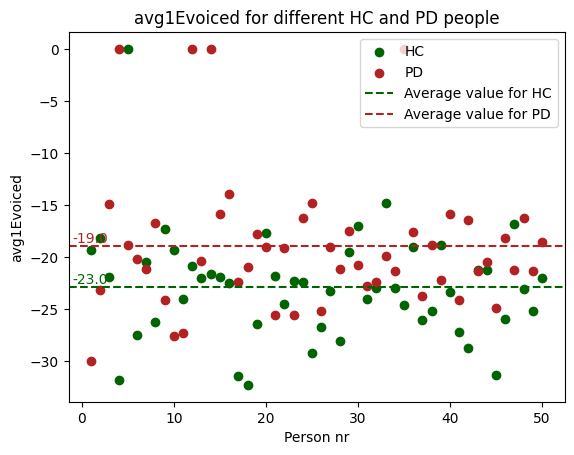

 
The average value for avgEvoiced is: 
   Over the 50 people in HC was -19.680942737565893
   Over the 50 people with PD was -17.38501267452572


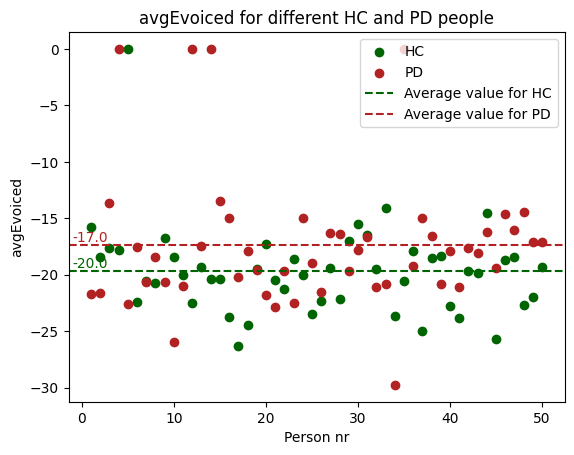

,F0avg,F0std,F0max,F0min,F0skew,F0kurt,F0tiltavg,F0mseavg,F0tiltstd,F0msestd,...,kurtosisdurpause,maxdurpause,mindurpause,PVU,PU,UVU,VVU,VP,UP,id
0,106.583977,19.399397,141.327927,79.098030,-0.088292,-1.523423,-36.004909,22.566310,69.942527,13.556839,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AVPEPUDEA0001_micasa.wav
1,222.202896,34.751759,290.076935,161.685715,0.236186,-0.849641,-107.358573,175.710059,51.545250,159.252488,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AVPEPUDEA0002_micasa.wav
2,211.934265,22.665243,260.311310,160.165558,-0.458662,-0.093548,-143.885608,27.038691,88.064751,30.011186,...,-2.0,0.18,0.17,0.688525,1.627907,0.422951,0.577049,0.838095,0.614286,AVPEPUDEA0003_micasa.wav
3,144.741959,13.445487,176.655991,111.665665,-0.016808,-0.644368,-18.525767,113.833455,0.000000,0.000000,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AVPEPUDEA0005_micasa.wav


,avg1Evoiced,avgEvoiced
0,-29.940335,-21.699731
1,-23.148063,-21.583513
2,-14.916885,-13.620348
3,0.000000,0.000000
4,-18.808507,-22.614279
5,-20.166576,-17.564325
6,-21.098290,-20.643094
7,-16.730138,-18.445855
8,-24.102251,-20.640905
9,-27.605506,-25.936829


['avg BBEon_1', 'avg BBEon_2', 'avg BBEon_3', 'avg BBEon_4', 'avg BBEon_5', 'avg BBEon_6', 'avg BBEon_7', 'avg BBEon_8', 'avg BBEon_9', 'avg BBEon_10', 'avg BBEon_11', 'avg BBEon_12', 'avg BBEon_13', 'avg BBEon_14', 'avg BBEon_15', 'avg BBEon_16', 'avg BBEon_17', 'avg BBEon_18', 'avg BBEon_19', 'avg BBEon_20', 'avg BBEon_21', 'avg BBEon_22', 'avg MFCCon_1', 'avg MFCCon_2', 'avg MFCCon_3', 'avg MFCCon_4', 'avg MFCCon_5', 'avg MFCCon_6', 'avg MFCCon_7', 'avg MFCCon_8', 'avg MFCCon_9', 'avg MFCCon_10', 'avg MFCCon_11', 'avg MFCCon_12', 'avg DMFCCon_1', 'avg DMFCCon_2', 'avg DMFCCon_3', 'avg DMFCCon_4', 'avg DMFCCon_5', 'avg DMFCCon_6', 'avg DMFCCon_7', 'avg DMFCCon_8', 'avg DMFCCon_9', 'avg DMFCCon_10', 'avg DMFCCon_11', 'avg DMFCCon_12', 'avg DDMFCCon_1', 'avg DDMFCCon_2', 'avg DDMFCCon_3', 'avg DDMFCCon_4', 'avg DDMFCCon_5', 'avg DDMFCCon_6', 'avg DDMFCCon_7', 'avg DDMFCCon_8', 'avg DDMFCCon_9', 'avg DDMFCCon_10', 'avg DDMFCCon_11', 'avg DDMFCCon_12', 'avg BBEoff_1', 'avg BBEoff_2', 'av

In [203]:
# Get multiple features example: 
# Need to look into a better way to just extract multiple features to a new list 
# for when I am testing with multiple features. For now this will work. 

prosody_feature_types = ["avg1Evoiced", "avgEvoiced"]
# prosody_feature_types= ['avgEvoiced', 'stdEvoiced', 'skwEvoiced', 'kurtosisEvoiced', 'avgtiltEvoiced', 'stdtiltEvoiced', 'skwtiltEvoiced', 'kurtosistiltEvoiced', 'avgmseEvoiced', 'stdmseEvoiced', 'skwmseEvoiced', 'kurtosismseEvoiced', 'avg1Evoiced', 'std1Evoiced', 'max1Evoiced', 'min1Evoiced', 'skw1Evoiced', 'kurtosis1Evoiced', 'avglastEvoiced', 'stdlastEvoiced', 'maxlastEvoiced', 'minlastEvoiced', 'skwlastEvoiced', 'kurtosislastEvoiced', 'avgEunvoiced', 'stdEunvoiced', 'skwEunvoiced', 'kurtosisEunvoiced', 'avgtiltEunvoiced', 'stdtiltEunvoiced', 'skwtiltEunvoiced', 'kurtosistiltEunvoiced', 'avgmseEunvoiced', 'stdmseEunvoiced', 'skwmseEunvoiced', 'kurtosismseEunvoiced', 'avg1Eunvoiced', 'std1Eunvoiced', 'max1Eunvoiced', 'min1Eunvoiced', 'skw1Eunvoiced', 'kurtosis1Eunvoiced', 'avglastEunvoiced', 'stdlastEunvoiced', 'maxlastEunvoiced', 'minlastEunvoiced', 'skwlastEunvoiced', 'kurtosislastEunvoiced']

# Removes ["que_sobra_HC"] and ["que_sobra_PD"] in this process. 
choosen_features = create_choosen_features(prosody_feature_types, features["Prosody"])
plot_features(choosen_features, prosody_feature_types)

display(features["Prosody"]["PD"].loc[0:3])

display(features["Prosody"]["PD"].loc[:, prosody_feature_types])





In [5]:
print(features["Prosody"]["PD"].keys().to_list())

['F0avg', 'F0std', 'F0max', 'F0min', 'F0skew', 'F0kurt', 'F0tiltavg', 'F0mseavg', 'F0tiltstd', 'F0msestd', 'F0tiltmax', 'F0msemax', 'F0tiltmin', 'F0msemin', 'F0tiltskw', 'F0mseskw', 'F0tiltku', 'F0mseku', '1F0mean', '1F0std', '1F0max', '1F0min', '1F0skw', '1F0ku', 'lastF0avg', 'lastF0std', 'lastF0max', 'lastF0min', 'lastF0skw', 'lastF0ku', 'avgEvoiced', 'stdEvoiced', 'skwEvoiced', 'kurtosisEvoiced', 'avgtiltEvoiced', 'stdtiltEvoiced', 'skwtiltEvoiced', 'kurtosistiltEvoiced', 'avgmseEvoiced', 'stdmseEvoiced', 'skwmseEvoiced', 'kurtosismseEvoiced', 'avg1Evoiced', 'std1Evoiced', 'max1Evoiced', 'min1Evoiced', 'skw1Evoiced', 'kurtosis1Evoiced', 'avglastEvoiced', 'stdlastEvoiced', 'maxlastEvoiced', 'minlastEvoiced', 'skwlastEvoiced', 'kurtosislastEvoiced', 'avgEunvoiced', 'stdEunvoiced', 'skwEunvoiced', 'kurtosisEunvoiced', 'avgtiltEunvoiced', 'stdtiltEunvoiced', 'skwtiltEunvoiced', 'kurtosistiltEunvoiced', 'avgmseEunvoiced', 'stdmseEunvoiced', 'skwmseEunvoiced', 'kurtosismseEunvoiced', 'avg

In [124]:
label_mapping = {"HC": 0, "PD": 1}


def get_healt_state(value, dict=label_mapping):
    """
    Function to get healt state from number 0 or one using the label mapping dict in the opposite way. 
    
    The functionality to get the key from the value from a dict is taken from: 
    https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/
    
    :param value: The value 0 or 1 we want to get the health state for. 
    :param dict: The mapping between 0 and 1 and healt states. (default to label_mapping)
    :return: the string showing if it is HC or PD (the healt state). 
    """
    key = list(filter(lambda x: dict[x] == value, dict))[0]
    return key

In [125]:
# Initialize lists to store samples and labels
values = []
labels = []

print(choosen_features.keys())

# Iterate through the feature dictionary
for label, value in choosen_features.items():
    value = np.array(value)
    values.extend(value)  # Extend the features list with the samples for each label
    num_label = label_mapping[label]
    labels.extend([num_label] * len(value))  # Add labels corresponding to each feature

# Convert samples and labels to numpy arrays
num_features = len(values[0])
x = np.array(values).reshape(-1, num_features, 1)
y = np.array(labels)

display(x[0])
display(np.array(choosen_features["HC"].loc[0]).reshape(num_features, 1))


dict_keys(['HC', 'PD'])


array([[-19.321091  ],
       [-15.76315712]])

array([[-19.321091  ],
       [-15.76315712]])

In [126]:
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=shape),
        layers.Conv1D(32, kernel_size=2, padding='same', activation='relu'),
        layers.Conv1D(16, kernel_size=2, padding='same', activation='relu'),
        layers.Conv1D(2 * 256, kernel_size=2, padding='same', activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(2, activation='softmax')  # Output layer with 2 classes
    ])

    return model


shape = x[0].shape  # shape = (2,1) # If num_features = 2 
# Create and compile the model
cnn_model = create_cnn_model()
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_369 (Conv1D)         (None, 2, 32)             96        
                                                                 
 conv1d_370 (Conv1D)         (None, 2, 16)             1040      
                                                                 
 conv1d_371 (Conv1D)         (None, 2, 512)            16896     
                                                                 
 global_average_pooling1d_1  (None, 512)               0         
 23 (GlobalAveragePooling1D                                      
 )                                                               
                                                                 
 dense_123 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 19058 (74.45 KB)
Trainable params: 190

## Using train, test, val split

In [127]:
# Split the data into training, validation, and testing sets (60% training, 20% validation, 20% testing)
train_data, temp_data, train_labels, temp_labels = train_test_split(x, y, test_size=0.4, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
print("  ")
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(60, 2, 1)
(20, 2, 1)
(20, 2, 1)
  
(60,)
(20,)
(20,)


In [128]:
# Train the model
cnn_model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_data=(val_data, val_labels))

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(test_data, test_labels, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/20
2/2 [==============================] - 2s 339ms/step - loss: 0.8393 - accuracy: 0.5000 - val_loss: 0.6884 - val_accuracy: 0.5500
Epoch 2/20
2/2 [==============================] - 0s 44ms/step - loss: 0.7802 - accuracy: 0.4500 - val_loss: 0.7135 - val_accuracy: 0.5500
Epoch 3/20
2/2 [==============================] - 0s 56ms/step - loss: 0.7463 - accuracy: 0.4667 - val_loss: 0.6829 - val_accuracy: 0.6000
Epoch 4/20
2/2 [==============================] - 0s 53ms/step - loss: 0.6881 - accuracy: 0.5667 - val_loss: 0.7590 - val_accuracy: 0.4500
Epoch 5/20
2/2 [==============================] - 0s 47ms/step - loss: 0.7283 - accuracy: 0.5500 - val_loss: 0.8034 - val_accuracy: 0.4500
Epoch 6/20
2/2 [==============================] - 0s 46ms/step - loss: 0.7332 - accuracy: 0.5500 - val_loss: 0.7463 - val_accuracy: 0.4500
Epoch 7/20
2/2 [==============================] - 0s 62ms/step - loss: 0.6968 - accuracy: 0.5500 - val_loss: 0.6929 - val_accuracy: 0.4500
Epoch 8/20
2/2 [==========

1/1 [==============================] - 0s 177ms/step
Confusion Matrix:
[[ 1 11]
 [ 3  5]]
 
Confusion Matrix in percentage:
[[ 8.33333333 91.66666667]
 [37.5        62.5       ]]
 
[0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0]
[1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1]


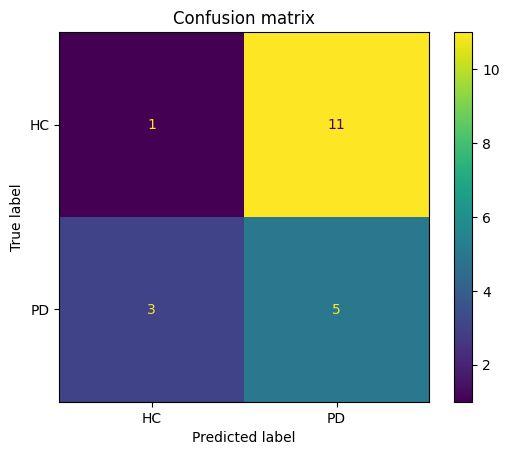

In [129]:

# Make predictions on the test set
y_pred = np.argmax(cnn_model.predict(test_data), axis=1)

# Define your class labels
class_labels = ["HC", "PD"]  # Replace with your actual class labels

# Generate the confusion matrix with labels
confusion_mat_percentage = confusion_matrix(test_labels, y_pred, labels=range(len(class_labels)), normalize="true")
confusion_mat = confusion_matrix(test_labels, y_pred, labels=range(len(class_labels)))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

print(" ")
# Print the confusion matrix
print("Confusion Matrix in percentage:")
print(confusion_mat_percentage * 100)
print(" ")

print(test_labels)
print(y_pred)
# print(test_data)

# Display the confusion matrix: 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=class_labels)
disp.plot()
plt.title("Confusion matrix")
plt.show()



In [130]:
# Display a more detailed classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

          HC       0.25      0.08      0.12        12
          PD       0.31      0.62      0.42         8

    accuracy                           0.30        20
   macro avg       0.28      0.35      0.27        20
weighted avg       0.28      0.30      0.24        20


In [131]:
# Testing the model for one example: // Method 1 
test_sample = np.array(choosen_features["HC"].loc[10])
true = label_mapping["HC"]

test_sample = test_sample.reshape(-1, num_features, 1)

# Predict the class label
pred = np.argmax(cnn_model.predict(test_sample), axis=1)[0]

# Compare the predicted and true labels
if pred == true:

    print(f"The model correctly predicted the gesture: {get_healt_state(pred)}")
else:
    print(f"The model predicted {get_healt_state(pred)} but the true gesture was {get_healt_state(true)}")


1/1 [==============================] - 0s 42ms/step
The model predicted PD but the true gesture was HC


In [132]:
# Testing the model for one example: // METHOD 2
test_sample = train_data[0]
true = train_labels[0]

test_sample = test_sample.reshape(-1, num_features, 1)

# Predict the class label
pred = np.argmax(cnn_model.predict(test_sample), axis=1)[0]
# Compare the predicted and true labels
if pred == true:

    print(f"The model correctly predicted the gesture: {get_healt_state(pred)}")
else:
    print(f"The model predicted {get_healt_state(pred)} but the true gesture was {get_healt_state(true)}")


1/1 [==============================] - 0s 45ms/step
The model predicted PD but the true gesture was HC


## Using 5 fold cross validation: 

 
This is data for fold number 1: 
1/1 - 0s - loss: 0.6443 - accuracy: 0.6000 - 47ms/epoch - 47ms/step
Fold Test Accuracy: 60.00%
1/1 [==============================] - 0s 160ms/step
True labels:  [1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1]
Pred labels:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Confusion Matrix:
[[10  0]
 [ 8  2]]
 
This is data for fold number 2: 
1/1 - 0s - loss: 0.6701 - accuracy: 0.5000 - 16ms/epoch - 16ms/step
Fold Test Accuracy: 50.00%
1/1 [==============================] - 0s 85ms/step
True labels:  [0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0]
Pred labels:  [0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1]
Confusion Matrix:
[[5 5]
 [5 5]]
 
This is data for fold number 3: 
1/1 - 0s - loss: 0.6986 - accuracy: 0.5500 - 22ms/epoch - 22ms/step
Fold Test Accuracy: 55.00%
1/1 [==============================] - 0s 85ms/step
True labels:  [1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0]
Pred labels:  [1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0]
Confusion Matrix:
[[8 2]
 [7 3]]
 
This is data

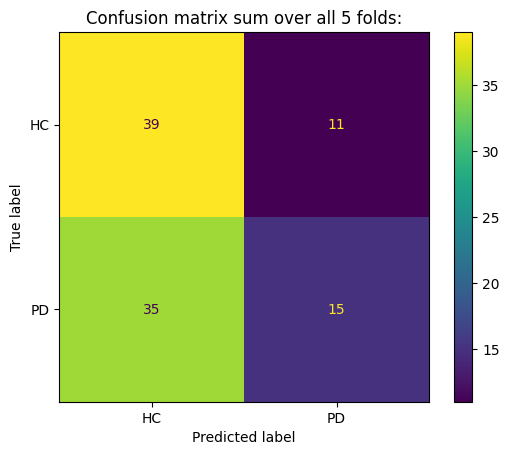

In [133]:
number_of_folds = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=42)

# My x data is first only 0's and then only 1's so to get it more random it gets shuffled first. 
indices = np.arange(len(x))
np.random.shuffle(indices)

shuffled_x = x[indices]
shuffled_y = y[indices]

accuracy_scores = []  # list to store accuracy scores
confusion_mat_sum = np.array([[0, 0], [0, 0]])
fold_num = 0

for train_index, test_index in skf.split(shuffled_x, shuffled_y):  # Iterate through folds 
    fold_num += 1
    print(" ")
    print(f"This is data for fold number {fold_num}: ")

    # Split the data into train and test sets for this fold
    # This type of splitting makes it so that all of the values are test values at some point, 
    # And for each fold we have a 80-20 split. 
    x_train, x_test = shuffled_x[train_index], shuffled_x[test_index]
    y_train, y_test = shuffled_y[train_index], shuffled_y[test_index]

    shape = x[0].shape  # shape = (2,1) # If num_features = 2 

    # Create and compile the model
    cnn_model = create_cnn_model()
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    cnn_model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), verbose=0)

    # Evaluate the model on the test set
    test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=2)
    print(f"Fold Test Accuracy: {test_accuracy * 100:.2f}%")
    accuracy_scores.append(test_accuracy)

    # Make predictions on the test set
    y_pred = np.argmax(cnn_model.predict(x_test), axis=1)

    # Generate the confusion matrix with labels
    confusion_mat = confusion_matrix(y_test, y_pred, labels=range(len(class_labels)))
    confusion_mat_sum += confusion_mat

    print("True labels: ", y_test)
    print("Pred labels: ", y_pred)

    # Display a more detailed classification report
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_pred, target_names=class_labels))

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(confusion_mat)

# Display average accuracy across all folds
print(" ")
print(f"Result over all {fold_num} folds:")
print(f"Average Accuracy: {np.mean(accuracy_scores) * 100:.2f}%")

# Print the confusion matrix sum:
print("Sum of all confusion Matrix:")
print(confusion_mat_sum)

# Display the confusion matrix: 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_sum, display_labels=class_labels)
disp.plot()
plt.title(f"Confusion matrix sum over all {fold_num} folds:")
plt.show()
